In [31]:
# !pip install numpy pandas pandas_ta matplotlib yfinance keras tensorflow pandas_datareader

In [32]:
# Importing libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import pandas_ta as ta

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing sklearn stuff
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# Importing libraries for fetching financial data
import yfinance as yf

# Importing libraries for deep learning with Keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from tensorflow.keras.models import load_model

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History, EarlyStopping
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

# Importing additional libraries
import datetime
import math
import pandas_datareader as pdr

In [33]:
ROOT='./kaggle/input/dt23-test/series'

def csv_to_df_handler(path):
    out_df = pd.read_csv(ROOT+path,index_col='timestamp')
    out_df.index = pd.to_datetime(out_df.index)
    out_df = out_df.sort_index(ascending=True).replace([np.inf, -np.inf], np.nan).interpolate(method='linear').fillna(0)
    return out_df

In [34]:

def fetch_combined_data(stock_symbol):
    # Fetch stock data from yfinance
    stock_df = yf.download(tickers=stock_symbol, start='2000-01-01').interpolate(method='linear')

    # Define the economic data series IDs from FRED
    fred_series_ids = {
        'CPI': 'CPIAUCSL',  # US CPI
        'M1': 'M1',  # M1 Money Supply
        'US_10Y_Bond_Yield': '^TNX'  # US 10-year bond yield (from yfinance)
    }

    # FRED doesn't have a direct measure for US inflation, so it might need to be calculated or sourced differently

    # Fetch economic data from FRED and merge with stock data
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')
    for key, series_id in fred_series_ids.items():
        if key == 'US_10Y_Bond_Yield':  # Fetch bond yield from yfinance
            bond_df = yf.download(tickers=series_id, start='2000-01-01').interpolate(method='linear')
            stock_df = stock_df.join(bond_df['Close'].rename(key), how='left')
        else:
            fred_df = pdr.get_data_fred(series_id, start='2000-01-01', end=end_date)
            stock_df = stock_df.join(fred_df, how='left')

    return stock_df


In [35]:
SPY_df = fetch_combined_data('SPY')
ISRG_df = fetch_combined_data('ISRG')
SPY_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,CPIAUCSL,M1,US_10Y_Bond_Yield
Date,,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,94.262550,8164300,NaN,1138.6,6.548
2000-01-04,143.53125,144.06250,139.640625,139.7500,90.576294,8089800,NaN,NaN,6.485
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.738350,12177900,NaN,NaN,6.599
2000-01-06,139.62500,141.50000,137.750000,137.7500,89.280106,6227200,NaN,NaN,6.549
2000-01-07,140.31250,145.75000,140.062500,145.7500,94.465088,8066500,NaN,NaN,6.504


In [36]:
# help(ta.bop)

In [37]:


def add_indicators(data):
    # Trend Indicators
    data['EMA12'] = ta.ema(data['Adj Close'], length=12)
    data['EMA25'] = ta.ema(data['Adj Close'], length=25)
    data['EMA50'] = ta.ema(data['Adj Close'], length=50)
    data['EMA100'] = ta.ema(data['Adj Close'], length=100)
    data['EMA200'] = ta.ema(data['Adj Close'], length=200)
    data['BOP'] = ta.bop(open_= data['Open'], high=data['High'], low=data['Low'], close=data['Adj Close'])

    # ADX Indicator
    adx_values = ta.adx(high=data['High'], low=data['Low'], close=data['Adj Close'])
    data['ADX'] = adx_values['ADX_14']
    data['+DI'] = adx_values['DMP_14']
    data['-DI'] = adx_values['DMN_14']

    # Momentum Indicators
    data['RSI'] = ta.rsi(data['Adj Close'], length=15)
    
    # Stochastic Oscillator
    stoch_values = ta.stoch(high=data['High'], low=data['Low'], close=data['Adj Close'])
    data['STOCH_K'] = stoch_values['STOCHk_14_3_3']  # Stochastic %K line
    data['STOCH_D'] = stoch_values['STOCHd_14_3_3']  # Stochastic %D line

    # Volume Indicator
    data['OBV'] = ta.obv(close=data['Adj Close'], volume=data['Volume'])

    # Volatility Indicator
    data['ZSCORE'] = ta.zscore(close=data['Adj Close'])
    bbands = ta.bbands(close=data['Adj Close'], length=20, std=2, mamode='sma')
    # print(bbands.columns)  # Print to check the column names

    # Update the DataFrame with the correct column names
    # Replace 'BB_LOWER', 'BB_MIDDLE', 'BB_UPPER' with actual column names from bbands.columns
    data['BB_LOWER'] = bbands['BBL_20_2.0']  # Update with the actual column name for lower band
    data['BB_MIDDLE'] = bbands['BBM_20_2.0']   # Update with the actual column name for middle band
    data['BB_UPPER'] = bbands['BBU_20_2.0']  # Update with the actual column name for upper band
     # MACD (also a momentum indicator)
    macd = ta.macd(data['Adj Close'], fast=12, slow=26, signal=9)
    data['MACD'] = macd['MACD_12_26_9']
    data['MACD_Signal'] = macd['MACDs_12_26_9']
    data['MACD_Hist'] = macd['MACDh_12_26_9']

    # Performance Indicators
    data['proportional_variation_compared_to_previous_day'] = ta.percent_return(data['Adj Close'], cumulative=False)
    data['proportional_variation_compared_to_start'] = ta.percent_return(data['Adj Close'], cumulative=True)

    # Target and Classification
    #target value is the percentage variation of tomorrow compared to today
    data['Target'] = data['proportional_variation_compared_to_previous_day'].shift(-1)
    data.fillna(0, inplace=True)

    return data

In [38]:
SPY_df = add_indicators(SPY_df)
SPY_df.head()

,Open,High,Low,Close,Adj Close,Volume,CPIAUCSL,M1,US_10Y_Bond_Yield,EMA12,...,ZSCORE,BB_LOWER,BB_MIDDLE,BB_UPPER,MACD,MACD_Signal,MACD_Hist,proportional_variation_compared_to_previous_day,proportional_variation_compared_to_start,Target
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,94.262550,8164300,0.0,1138.6,6.548,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.039106
2000-01-04,143.53125,144.06250,139.640625,139.7500,90.576294,8089800,0.0,0.0,6.485,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.039106,-0.039106,0.001789
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.738350,12177900,0.0,0.0,6.599,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001789,-0.037387,-0.016071
2000-01-06,139.62500,141.50000,137.750000,137.7500,89.280106,6227200,0.0,0.0,6.549,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016071,-0.052857,0.058075
2000-01-07,140.31250,145.75000,140.062500,145.7500,94.465088,8066500,0.0,0.0,6.504,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058075,0.002149,0.003431


## A glance at correlation and variance


In [39]:
def corr_heatmap(df):
    # Reset the index to remove it from the correlation calculation
    df_reset_index = df.reset_index(drop=True)
    
    graph_size = (12, 12)
    fig, ax = plt.subplots(figsize=graph_size)
    sns.heatmap(df_reset_index.corr(), ax=ax, vmin=-1, vmax=1, cmap='coolwarm')
    plt.show()


In [40]:
SPY_df.var()

Open                                               1.081584e+04
High                                               1.092815e+04
Low                                                1.069522e+04
Close                                              1.082059e+04
Adj Close                                          1.254555e+04
Volume                                             8.545535e+15
CPIAUCSL                                           1.564057e+03
M1                                                 2.492338e+06
US_10Y_Bond_Yield                                  1.743958e+00
EMA12                                              1.251768e+04
EMA25                                              1.248538e+04
EMA50                                              1.241679e+04
EMA100                                             1.228040e+04
EMA200                                             1.202750e+04
BOP                                                2.108779e+02
ADX                                     

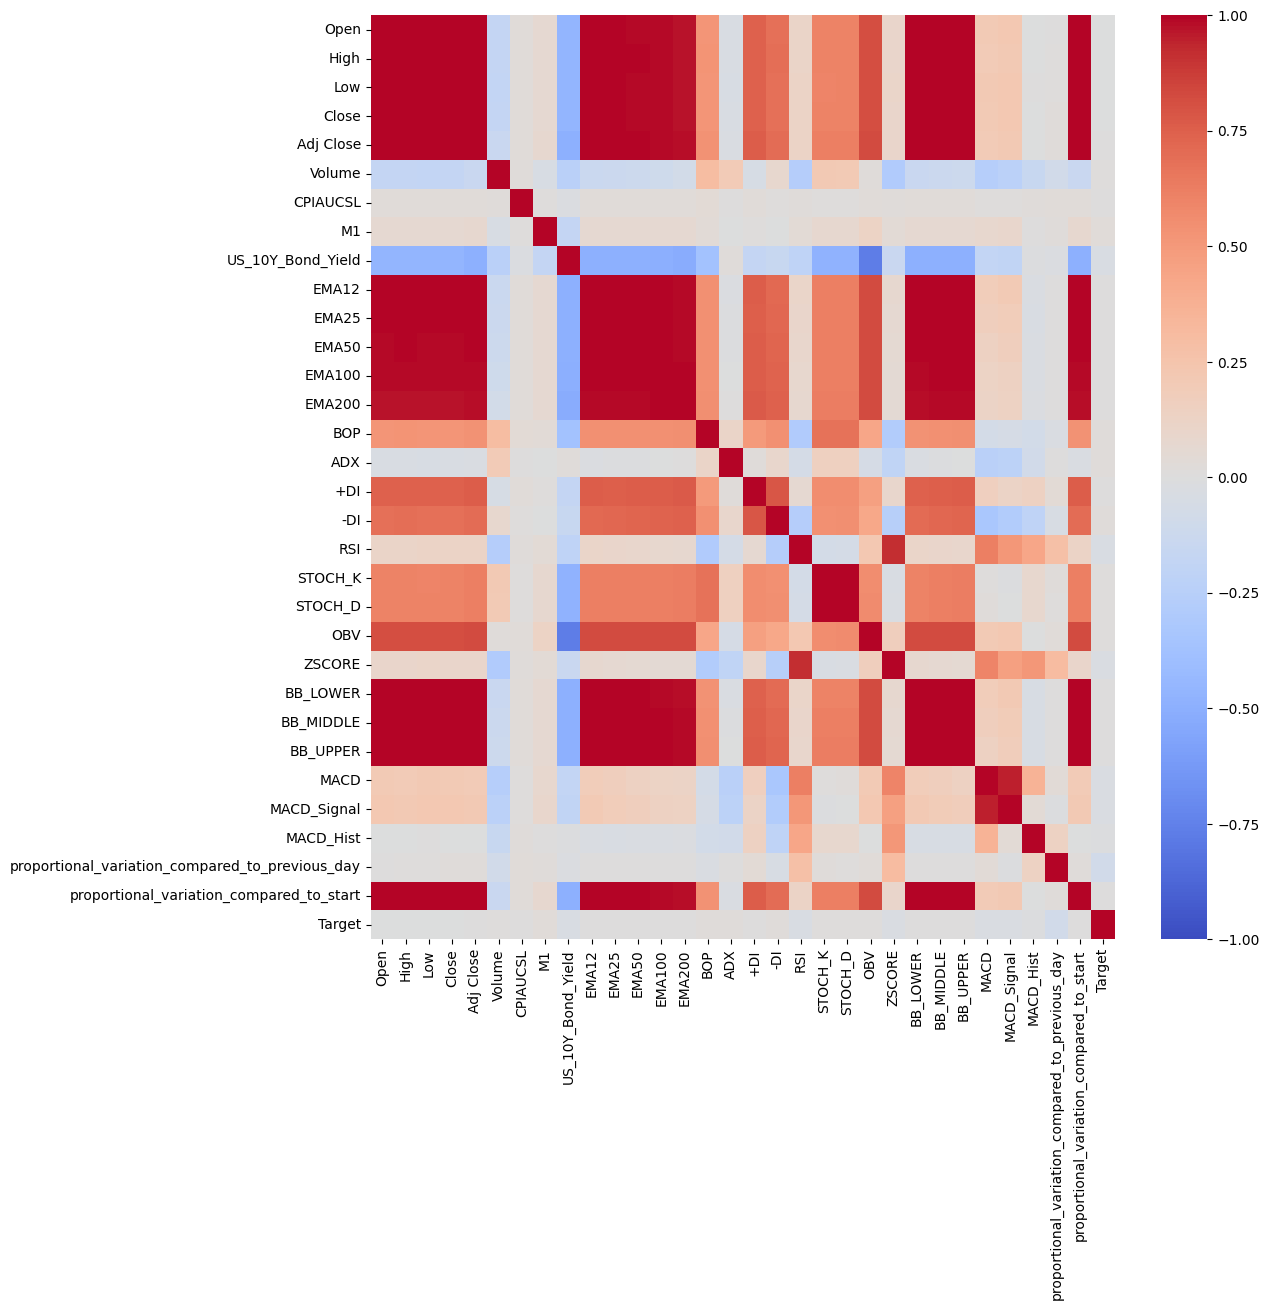

In [41]:
corr_heatmap(SPY_df)

## ML pipeline functions

In [42]:
# Scaler for data normalization
sc = MinMaxScaler(feature_range=(0, 1))

def refit_data_for_ml(df, backcandles):
    # Drop specified columns, fill missing values, reset index
    df = df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'proportional_variation_compared_to_start'], axis=1).fillna(0).reset_index(drop=True)
    df = sc.fit_transform(df)

    # Generate sequences for LSTM
    X = []
    input_cols_num = df.shape[1] - 1
    for j in range(input_cols_num):
        X.append([df[i-backcandles:i, j] for i in range(backcandles, df.shape[0])])

    # Rearrange array dimensions
    X = np.moveaxis(X, 0, 2)
    X, y = np.array(X), np.array(df[backcandles:, -1])
    y = np.reshape(y, (len(y), 1))

    return X, y, sc

def split_ml_dataset(X, y):
    splitlimit = int(len(X) * 0.8)
    X_train, X_test = X[:splitlimit], X[splitlimit:]
    y_train, y_test = y[:splitlimit], y[splitlimit:]

    return X_train, X_test, y_train, y_test

def create_model(num_features, backcandles):
    model = Sequential()
    model.add(Input((backcandles, num_features)))
    model.add(LSTM(64))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
    return model

def train_model(model, X_train, y_train):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=int(math.ceil(X_train.shape[2] * 1.5)),
        epochs=100,
        shuffle=True,
        validation_split=0.1,
        callbacks=[early_stopping]
    )

    return model, history

def save_model(model, history):
    last_loss = history.history['loss'][-1]
    model.save(f'././model_save/LSTM_loss{last_loss:.4f}.keras')

def lstm_train_pipeline(dfs, backcandles):
    combined_df = pd.concat(dfs, ignore_index=True)
    X, y, scaler = refit_data_for_ml(combined_df, backcandles)
    X_train, X_test, y_train, y_test = split_ml_dataset(X, y)

    num_features = X_train.shape[2]
    backcandles = X_train.shape[1]

    model = create_model(num_features, backcandles)
    model, history = train_model(model, X_train, y_train)

    save_model(model, history)

    return model, scaler

def lstm_predict_pipeline(dfs, model, backcandles, scaler):
    for df in dfs:

        X, _, sc = refit_data_for_ml(df, backcandles)

        if scaler ==None:
            scaler = sc

        # Generate predictions
        y_pred = model.predict(X)

        # Detect the number of features
        num_features = len(scaler.scale_)

        # Expand the predictions array
        expanded_pred = np.zeros((y_pred.shape[0], num_features))
        expanded_pred[:, -1] = y_pred.ravel()

        # Rescale predictions
        y_pred_rescaled = scaler.inverse_transform(expanded_pred)[:, -1]

        # Handle the discrepancy in lengths
        padding = np.full((backcandles,), np.nan)
        full_predictions = np.concatenate([padding, y_pred_rescaled])

        # Append the predictions as a new column
        df['next_day_prediction'] = full_predictions

    return dfs


## Attempting feature selection 
key word: attempt


In [43]:
def get_important_features_with_tree(df, backcandles):
    # Prepare the data
    X, y, _ = refit_data_for_ml(df, backcandles)

    # Train a Random Forest model to get feature importances
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X.reshape(X.shape[0], -1), y.ravel())

    # Map feature importances to column names
    feature_importances = dict(zip(df.columns, rf.feature_importances_))

    # Sort the dictionary by importance score in descending order
    sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

    return sorted_feature_importances

In [44]:
# important_features = get_important_features(SPY_df,7)
# print(important_features)

## Trying our first Predicitons

In [47]:
LSTMmodel,scaler = lstm_train_pipeline([SPY_df],7)
# LSTMmodel = load_model('./model_save/LSTM_loss0.0024.h5')


Epoch 1/100
114/114 [==============================] - 2s 7ms/step - loss: 0.0150 - mean_absolute_error: 0.0688 - val_loss: 0.0018 - val_mean_absolute_error: 0.0294
Epoch 2/100
114/114 [==============================] - 1s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0342 - val_loss: 0.0022 - val_mean_absolute_error: 0.0348
Epoch 3/100
114/114 [==============================] - 1s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0344 - val_loss: 0.0017 - val_mean_absolute_error: 0.0288
Epoch 4/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0351 - val_loss: 0.0014 - val_mean_absolute_error: 0.0257
Epoch 5/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0341 - val_loss: 0.0013 - val_mean_absolute_error: 0.0238
Epoch 6/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0345 - val_loss: 0.0012 - val_mean_absolute_error: 0.0224
Epoch 7/10

In [ ]:
ISRG_df = add_indicators(ISRG_df)

predictions = lstm_predict_pipeline([ISRG_df,SPY_df], LSTMmodel, 7, scaler= None)



188/188 [==============================] - 0s 1ms/step


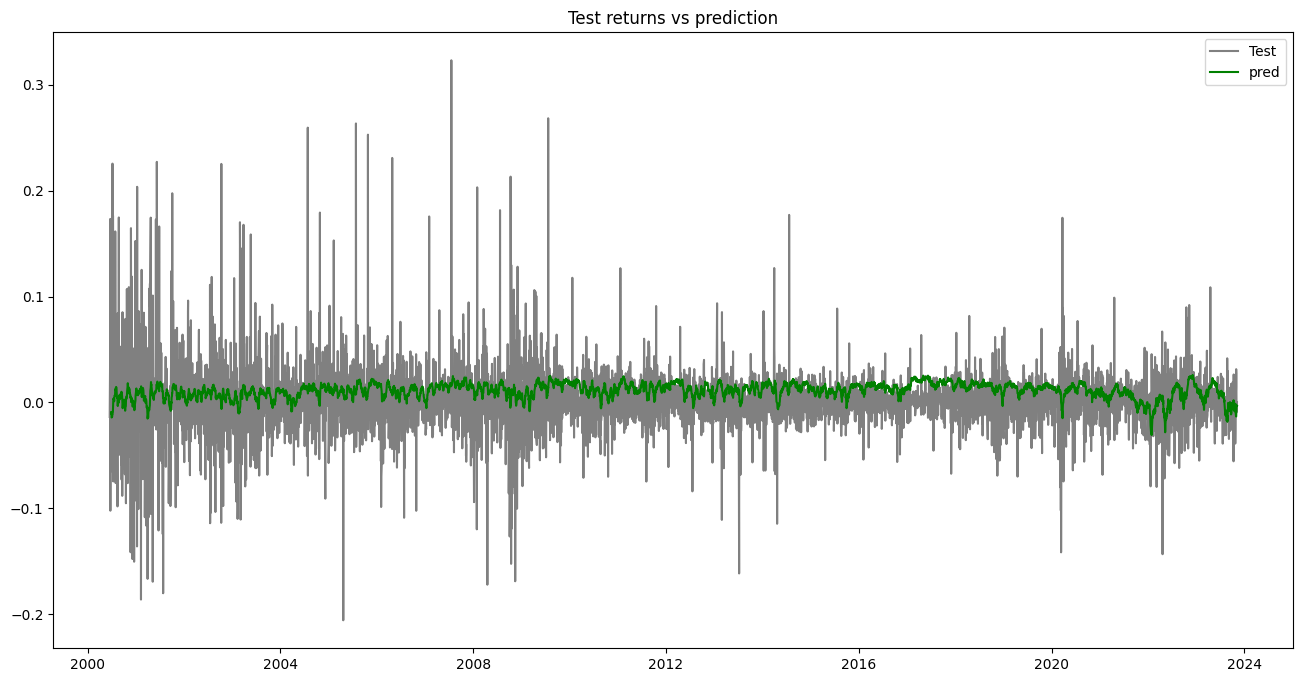

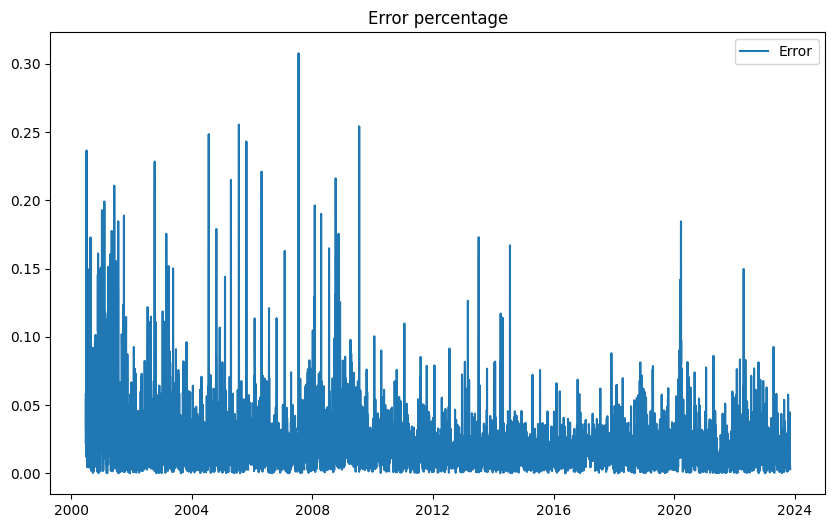

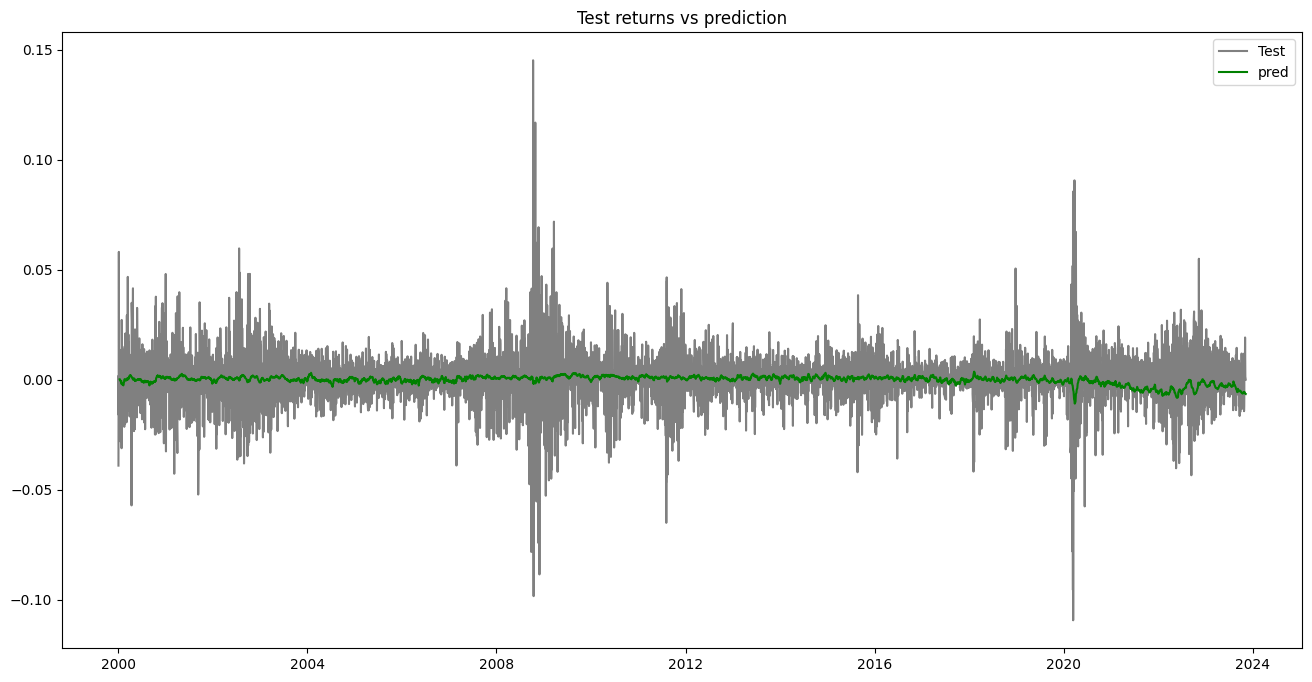

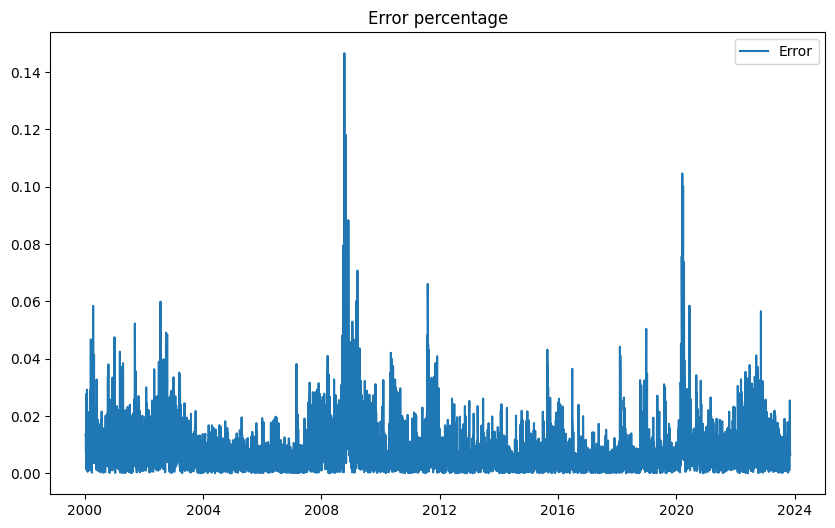

In [ ]:
for df_with_prediction in predictions:
    y_test = df_with_prediction['Target']
    y_pred = df_with_prediction['next_day_prediction']
    plt.figure(figsize=(16,8))
    plt.plot(y_test, color = 'grey', label = 'Test')
    plt.plot(y_pred, color = 'green', label = 'pred')
    plt.title('Test returns vs prediction')
    plt.legend()
    plt.show()

        # Calculate error between percentage differences
    df_with_prediction['error'] = abs(y_test - y_pred)

    # Plotting
    plt.figure(figsize=(10, 6))
    # plt.plot(df_with_prediction['pct_diff_SPY_ytest'], label='Percentage Difference SPY_ytest')
    # plt.plot(df_with_prediction['pct_diff_y_pred'], label='Percentage Difference y_pred')
    plt.plot(df_with_prediction['error'], label='Error')
    plt.title('Error percentage')
    plt.legend()
    plt.show()

In [ ]:
df_with_prediction

,Open,High,Low,Close,Adj Close,Volume,CPIAUCSL,M1,US_10Y_Bond_Yield,EMA12,...,BB_MIDDLE,BB_UPPER,MACD,MACD_Signal,MACD_Hist,proportional_variation_compared_to_previous_day,proportional_variation_compared_to_start,Target,next_day_prediction,error
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.437500,94.262566,8164300,0.0,1138.6,6.548,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.039106,NaN,NaN
2000-01-04,143.531250,144.062500,139.640625,139.750000,90.576340,8089800,0.0,0.0,6.485,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.039106,-0.039106,0.001789,NaN,NaN
2000-01-05,139.937500,141.531250,137.250000,140.000000,90.738365,12177900,0.0,0.0,6.599,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001789,-0.037387,-0.016072,NaN,NaN
2000-01-06,139.625000,141.500000,137.750000,137.750000,89.280045,6227200,0.0,0.0,6.549,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016072,-0.052858,0.058076,NaN,NaN
2000-01-07,140.312500,145.750000,140.062500,145.750000,94.465080,8066500,0.0,0.0,6.504,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.058076,0.002148,0.003431,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,416.179993,418.529999,414.209991,418.200012,418.200012,79665200,0.0,0.0,4.875,420.583605,...,425.778000,441.641716,-5.208441,-4.173976,-1.034465,0.006280,3.436544,0.010665,-0.006142,0.016807
2023-11-01,419.200012,423.500000,418.649994,422.660004,422.660004,98068100,0.0,0.0,4.789,420.903051,...,425.678000,441.593774,-4.656992,-4.270579,-0.386413,0.010665,3.483858,0.019164,-0.006261,0.025425
2023-11-02,426.579987,430.920013,426.559998,430.760010,430.760010,94938900,0.0,0.0,4.669,422.419506,...,425.991000,442.047396,-3.525720,-4.121607,0.595888,0.019164,3.569789,0.009123,-0.006344,0.015468


## Trying decision trees

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error
# import math
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error
# from joblib import load

# # Scaler for data normalization
# sc = MinMaxScaler(feature_range=(0,1))

# def refit_data_for_ml(df, backcandles):
#     # Drop specified columns, fill missing values, reset index
#     df = df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'proportional_variation_compared_to_start'], axis=1).fillna(0).reset_index(drop=True)
#     df = sc.fit_transform(df)

#     # Generate sequences
#     X = []
#     y = []
#     for i in range(backcandles, len(df)):
#         X.append(df[i-backcandles:i, :-1].flatten())
#         y.append(df[i, -1])

#     # Convert to numpy arrays
#     X, y = np.array(X), np.array(y)
#     return X, y, sc


# def save_model(model, filename_suffix):
#     model_path = f'./model_save/TREE_model_{filename_suffix}.h5'
#     # Save the model
#     from joblib import dump
#     dump(model, model_path)

# def train_decision_tree(X_train, y_train, max_depth=None, min_samples_split=2, ccp_alpha=0.0):
#     # Create and train the decision tree model with regularization parameters
#     model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, ccp_alpha=ccp_alpha)
#     model.fit(X_train, y_train)
#     return model
    
# def tree_train_pipeline(dfs, backcandles, max_depth=50, min_samples_split=2, ccp_alpha=0.0):
#     combined_df = pd.concat(dfs, ignore_index=True)
#     X, y, scaler = refit_data_for_ml(combined_df, backcandles)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     # If max_depth is None, train a single model without iterating over depths
#     if max_depth is None:
#       pass 

#     # If max_depth is not None, iterate over a range of depths to find the best model
#     best_score = float('inf')
#     best_model = None
#     for depth in range(1, max_depth+1):
#         model = train_decision_tree(X_train, y_train, max_depth=depth, min_samples_split=min_samples_split, ccp_alpha=ccp_alpha)
#         scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
#         mean_score = -scores.mean()
#         if mean_score < best_score:
#             best_score = mean_score
#             best_model = model

#     # Train the final model with the best depth found
#     final_model = train_decision_tree(X_train, y_train, max_depth=best_model.get_depth(), min_samples_split=min_samples_split, ccp_alpha=ccp_alpha)

#     # Calculate training and test errors
#     y_train_pred = final_model.predict(X_train)
#     train_error = mean_squared_error(y_train, y_train_pred)
#     y_test_pred = final_model.predict(X_test)
#     test_error = mean_squared_error(y_test, y_test_pred)

#     # Save the model with a filename suffix based on test error
#     save_model(final_model, f'loss{test_error:.4f}')

#     return final_model, scaler

# def tree_predict_pipeline(dfs, model, backcandles):
#     for df in dfs:
#         X,y, scaler = refit_data_for_ml(df, backcandles)

#         # Prepare data for prediction
#         X = []
#         for i in range(backcandles, len(df)):
#             X.append(df.iloc[i-backcandles:i, :-1].values.flatten())

#         X = np.array(X)

#         # Generate predictions
#         y_pred = model.predict(X)

#         # Rescale predictions
#         expanded_pred = np.zeros((y_pred.shape[0], len(scaler.scale_)))
#         expanded_pred[:, -1] = y_pred
#         y_pred_rescaled = scaler.inverse_transform(expanded_pred)[:, -1]

#         # Handle the discrepancy in lengths
#         padding = np.full((backcandles,), np.nan)
#         full_predictions = np.concatenate([padding, y_pred_rescaled])

#         # Append the predictions as a new column
#         df['next_day_prediction'] = full_predictions

#     return dfs


In [ ]:
# TREEmodel, scaler = tree_train_pipeline([SPY_df], 7)
# TREEmodel = load('./model_save/TREE_model_loss0.0031.h5')

In [ ]:
# predictions = tree_predict_pipeline([ISRG_df, SPY_df], TREEmodel,7)

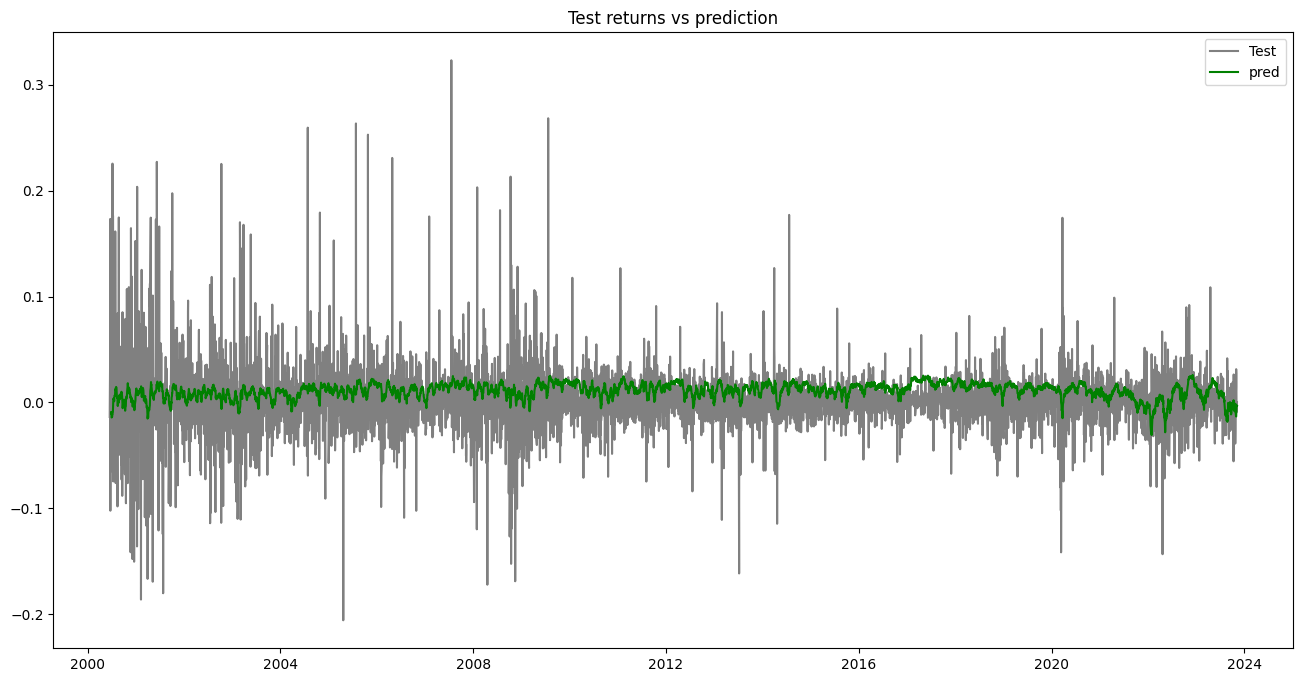

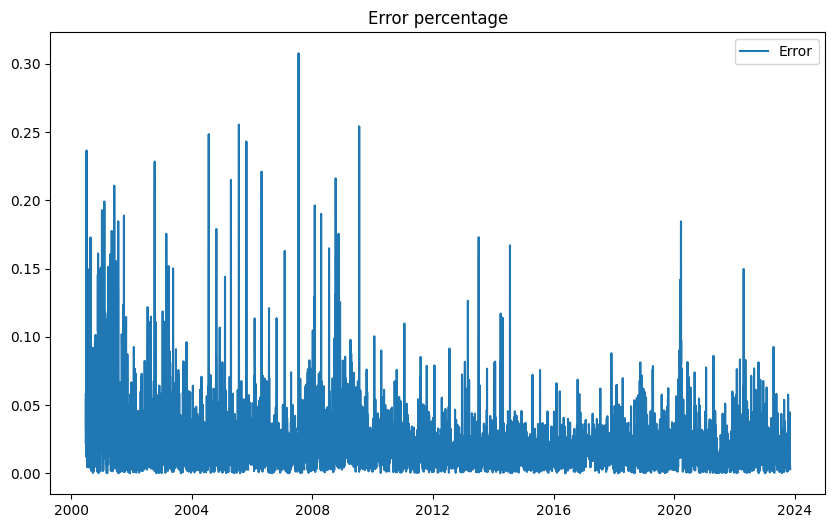

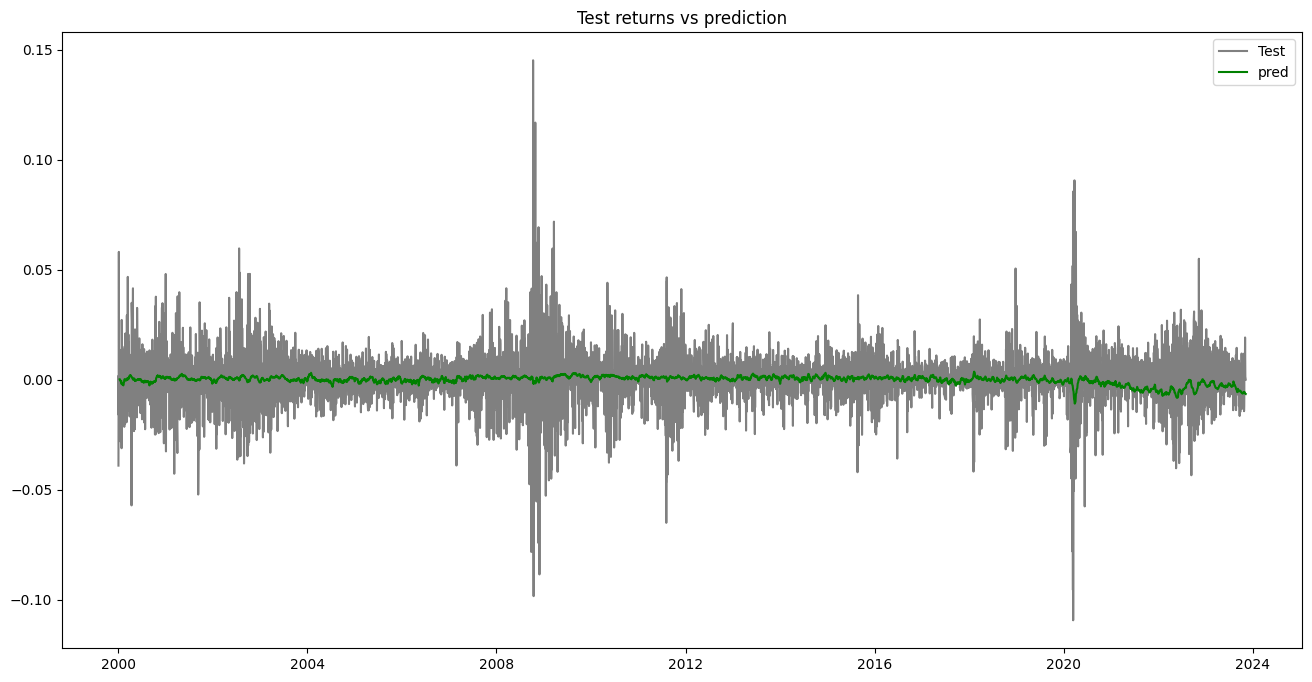

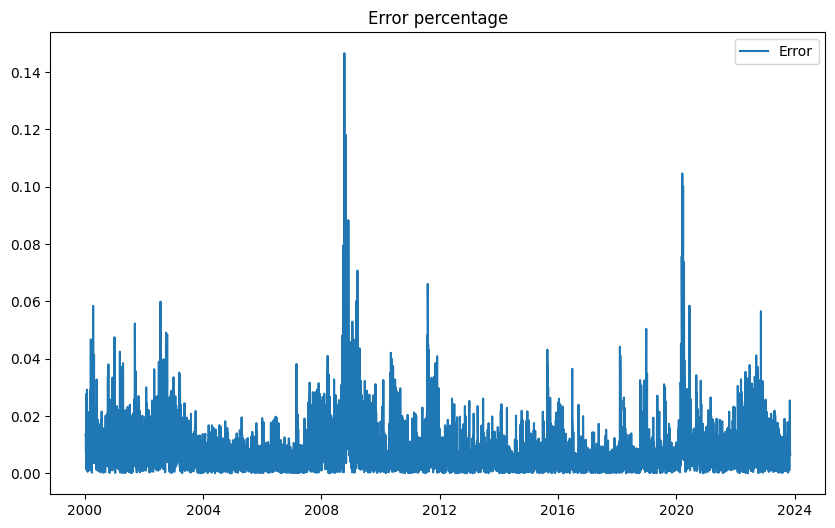

In [ ]:
for df_with_prediction in predictions:
    y_test = df_with_prediction['Target']
    y_pred = df_with_prediction['next_day_prediction']
    plt.figure(figsize=(16,8))
    plt.plot(y_test, color = 'grey', label = 'Test')
    plt.plot(y_pred, color = 'green', label = 'pred')
    plt.title('Test returns vs prediction')
    plt.legend()
    plt.show()

        # Calculate error between percentage differences
    df_with_prediction['error'] = abs(y_test - y_pred)

    # Plotting
    plt.figure(figsize=(10, 6))
    # plt.plot(df_with_prediction['pct_diff_SPY_ytest'], label='Percentage Difference SPY_ytest')
    # plt.plot(df_with_prediction['pct_diff_y_pred'], label='Percentage Difference y_pred')
    plt.plot(df_with_prediction['error'], label='Error')
    plt.title('Error percentage')
    plt.legend()
    plt.show()